In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import os
import re
import time
import random
from sklearn.cluster import KMeans

%matplotlib inline
sns.set()

<a id='0'></a>
# Outline
- The notebook shows the process in MRT_od_2_data_process.py and MRT_od_3_data_visualize.py
- The raw data in this whole project is created by __MRT_Cleaning_Visualizing__
- It is then processd by MRT_od_1_data_generator.py into a number of od files (215 files for 1 station)
- Since the raw data created from __MRT_Cleaning_Visualizing__ exceeding the github limit (100mb), here the notebook will begin from step 2, MRT_od_2_data_process.py, and used pre-generated data for illustration.

# Steps
1. [Data Process (with class StationOdInsight)](#1)
2. [Data Visualization (with class StationOdVisualize)](#2)

In [2]:

class StationOdInsight:
    def __init__(self, slicer, source_file_location, num_clusters, created_package_name):
        self.slicer = slicer       
        if self.slicer[-1] == '_':
            self.direction = 'from'
            self.station = self.slicer.split('_')[0]
        else:
            self.direction = 'to'
            self.station = self.slicer.split('_')[1]
        
        self.source_file_location = source_file_location
        self.num_clusters = num_clusters
        
        self.od_daily = {} #people count of daily average for each od 
        self.total_daily = 0 #daily total people for given direction
        self.accumu_sum = {} # accumulating people by od using sorted list (from largest od to smallest)
        self.accumu_ratio = {} # ratio version of previous step
        
        self.cluster = {}
        ##Keys in self.cluster:
        #raw = {} # od with its original cluster (ex 0, 1, 2)
        #checker = {} #group ods by its kmeans cluster 
        #people = {} #daily total people of each cluster group
        #station = {} #number of station in each cluster group
        #station_avg = {} #avg people of each station in each cluster group
        
        self.heatmap_data = {} #normalize table used for heatmap visualization
        self.colormap = {'o':{'A':'#08306b',
                              'B':'#2171b5',
                              'C':'#6baed6',
                              'D':'#9ecae1'},
                         'd':{'A':'#67000d',
                              'B':'#cb181d',
                              'C':'#fc9272',
                              'D':'#fcbba1'}}
               
        self.groupmap = {'o':{0:'A',
                              1:'B',
                              2:'C',
                              3:'D'},
                         'd':{0:'A',
                              1:'B',
                              2:'C',
                              3:'D'}}
        self.max_people_hr = {}
        
        
        # Create target Directory if don't exist
        if not os.path.exists(created_package_name):
            os.mkdir(created_package_name)
            print("Directory " , created_package_name ,  " Created ")
        else:    
            print("Directory " , created_package_name ,  " already exists")        
        
        self.output_location = './{}'.format(created_package_name)
     
    ## Attribute handler
    def setColorMap(self, dict_):
        print('set colormap')
        self.colormap = dict_
        
    def cluster_key_changer(self, to_be_changed, changer):
        #change key in dictionary:
        #https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary

        #to_be_changed format example : {1: 56884.05000000002, 0: 68918.31999999999, 2: 28883.590000000004} 
        #changer example: group_mapO = {0:'A',1:'B', 2:'C'}
        out_put = to_be_changed
        for old_k,new_k in changer.items():
            for original_k, v in out_put.items():
                if old_k == original_k:
                    out_put[new_k] = out_put.pop(original_k)
        return out_put
    
    #Define cluster name by pattern shown in the cluster, or simply giving "A, B, C..."
    def setGroupMap(self, dict_):
        print('reset cluster groupmap name')
        if self.direction == 'from':
            dict_ = dict_['o']
        else:
            dict_ = dict_['d']
            
        self.cluster['station'] = self.cluster_key_changer(self.cluster['station'], dict_)
        self.cluster['station_avg'] = self.cluster_key_changer(self.cluster['station_avg'], dict_)
        self.cluster['people']['count'] = self.cluster_key_changer(self.cluster['people']['count'], dict_)
        self.cluster['people']['ratio'] = self.cluster_key_changer(self.cluster['people']['ratio'], dict_)
        self.cluster['checker'] = self.cluster_key_changer(self.cluster['checker'], dict_)
        self.heatmap_data = self.cluster_key_changer(self.heatmap_data, dict_)
        self.max_people_hr = self.cluster_key_changer(self.max_people_hr, dict_)
        self.result_df(dict_)
        
    
    ## Basic function
    
    #get max value and its location in the dataframe
    def get_df_max(self, df):
        max_value = 0
        for item in df.columns:
            if df[item].max() > max_value:
                max_value = df[item].max()
                max_index = df[item].idxmax()
                max_cols = item
                max_loc = (max_index,max_cols)
        return max_value, max_loc

    def normalize_df(self, df):
        return round(df/self.get_df_max(df)[0],2)*100

    def station_table_to_list(self, station_sum_up, normalize_on):
        #1 normalizing data
        if normalize_on == 'normalize':
            normalize = round(station_sum_up/self.get_df_max(station_sum_up)[0],2)
        else:
            normalize = station_sum_up
        #2 transform to a list of lists
        middle_list = normalize.values.tolist()
        #3 transform to a single list
        result_list = [item for sub in middle_list for item in sub]

        return result_list    
    
    ##I. DATA PREPARATION
    #1. Get target od created by od_generator.  pattern example: 'BL11_' or '_BL11'
    def data_getter(self, slicer, file_location):
        od_dict = {}
        od_sum_dict = {}

        print('slicer in data_getter: {}'.format(slicer))
        for filename in os.listdir(file_location):
            if slicer[0] == '_':
                pattern = re.compile('{}$'.format(slicer))
                if re.search(pattern, filename[:-4]):
                    df = pd.read_csv('{}/{}'.format(file_location,filename),
                                     index_col=0,
                                     skiprows=[0,2],
                                     engine='python')
                    #station total traffic
                    od_sum = round(df.values.sum()/7,2)
                    #-4 for skipping file format, ".csv"
                    od_sum_dict[filename[:-4]] = od_sum
                              
                    lst = self.station_table_to_list(df,'normalize')
                    od_dict[filename[:-4]] = lst

            else:
                if re.match(slicer, filename):
                    df = pd.read_csv('{}/{}'.format(file_location,filename),
                                     index_col=0,
                                     skiprows=[0,2],
                                     engine='python')
                    
                    od_sum = round(df.values.sum()/7,2)                    
                    od_sum_dict[filename[:-4]] = od_sum
                    
                    lst = self.station_table_to_list(df,'normalize')
                    od_dict[filename[:-4]] = lst
        self.od_daily = od_sum_dict
        
        return od_dict
    
    #2. Run kmeans.
    def k_means(self, dict_, num_clusters):
        df_station_od = pd.DataFrame.from_dict(dict_).T
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df_station_od)
        df_station_od['cluster'] = kmeans.labels_
        
        return df_station_od['cluster']
    
    #3. create od cluster group 
    #setdefault
    #https://docs.quantifiedcode.com/python-anti-patterns/correctness/not_using_setdefault_to_initialize_a_dictionary.html
    def cluster_by_od(self, df_cluster_col):
        cluster_dict = {}
        for item in df_cluster_col.iteritems():
            cluster_dict.setdefault(item[1], []).append(item[0])
        self.cluster['checker'] = cluster_dict
        return cluster_dict  

    #4. create classified tables reading from files

    def heatmap_data_dict(self, cluster_dict):
        for_heatmap = {}
        max_people = {}
        for key in cluster_dict.keys():
            cluster_ods = {}
            max_ods = {}
            for od in cluster_dict[key]:
                #https://blog.csdn.net/ArcheriesYe/article/details/77992412
                df = pd.read_csv('{}/{}.csv'.format(self.source_file_location,od),
                                 index_col=0,
                                 skiprows=[0,2],
                                 engine='python')
                df_max = self.get_df_max(df)
                df = self.normalize_df(df)
                cluster_ods[od] = df
                max_ods[od] = df_max
            for_heatmap[key] = cluster_ods
            max_people[key] = max_ods
            
        print("Cluster result: {}".format([len(for_heatmap[x]) for x in for_heatmap]))
        
        self.heatmap_data = for_heatmap
        self.max_people_hr = max_people
        #return for_heatmap,max_people
    
    def ratio_calc(self, od_daily):
        sorted_od_daily = sorted(od_daily.items(), key=lambda kv: kv[1],reverse=True)
        total_avg = 0
        people_sum_dict = {}
        people_ratio_dict = {}
        for i in range(len(sorted_od_daily)):
            total_avg += sorted_od_daily[i][1]
            people_sum_dict[i+1] = total_avg
        for k,v in people_sum_dict.items():
            people_ratio_dict[k] = round(v/total_avg,3)

        self.total_daily = total_avg
        self.accumu_sum = people_sum_dict
        self.accumu_ratio = people_ratio_dict
        
    def cluster_ppl(self):
        data = {}
        data_count = {}
        data_ratio = {}
        total = 0
        #count people by cluster
        for cluster in self.cluster['checker']:
            data_count[cluster] = 0
            for od in self.cluster['checker'][cluster]:
                data_count[cluster] += round(self.od_daily[od],3)
            total += data_count[cluster]
        #data['total'] = total

        for cluster in data_count:
            data_ratio[cluster] = round(data_count[cluster]/total,3)
        
        data['count'] = data_count
        data['ratio'] = data_ratio
        
        self.cluster['people'] = data
     
    def cluster_station_generator(self):
        data = {}
        for k in self.cluster['checker']:
            data[k] = len(self.cluster['checker'][k])
        
        self.cluster['station'] = data
        
    def cluster_station_avg_generator(self):
        data = {}
        for cluster in self.cluster['people']['count']:
            people = self.cluster['people']['count'][cluster]
            station = self.cluster['station'][cluster]
            station_avg = round(people/station,2)
            data[cluster] = station_avg
        self.cluster['station_avg'] = data
    
    #Rename header for the result dataframe.
    def rename_dict(self):
        headers = []
        for weekday in ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']:
            for workinghours in ['00','01','05','06','07','08','09',
                                 '10','11','12','13','14','15','16',
                                 '17','18','19','20','21','22','23']:
                headers.append(weekday + '_' + workinghours)

        rename_dict = {}        
        for i in range(147):
            rename_dict[i] = headers[i]
        rename_dict[147] = 'cluster_group'
        rename_dict[148] = 'daily_ppl_avg'
        rename_dict[149] = 'max_people_by_hr'
        rename_dict[150] = 'max_weekday'
        rename_dict[151] = 'max_hour'
        return rename_dict

    def result_df(self, group_map):
        od_dict = {}
        for cluster in self.heatmap_data:
            for od, data in self.heatmap_data[cluster].items():
                #Transform hourly data from table to list, normalized, and add cluster type and daily avg. people 
                raw_data = self.heatmap_data[cluster][od]
                max_people_hourly = self.max_people_hr[cluster][od][0]
                refined_data = self.station_table_to_list(round(raw_data/100*max_people_hourly,2),'-')
                refined_data.extend((self.cluster['raw'][od],self.od_daily[od]))
                
                #Join the maximum people and its time with correct OD
                for cluster_in_max,od_under_cluster in self.max_people_hr.items():
                    for od_in_max,v in od_under_cluster.items():
                        if od_in_max == od:
                            refined_data.extend((v[0],v[1][0],v[1][1]))                  
                
                od_dict[od] = refined_data


        df_test = pd.DataFrame.from_dict(od_dict).T
        #https://stackoverflow.com/questions/12504976/get-last-column-after-str-split-operation-on-column-in-pandas-dataframe
        
        df_test['to'] = df_test.index.str.split('_').str[-1]
        df_test['from'] = df_test.index.str.split('_').str[-0]        
        df_test = df_test.rename(columns = self.rename_dict())
        
        #Add columns of cluster group name and color.
        if self.direction == 'from':
            colormap = self.colormap['o']
            df_test['group_name'] = df_test['cluster_group'].map(group_map)
            df_test['color'] = df_test['group_name'].map(colormap)
        else:
            colormap = self.colormap['d']
            df_test['group_name'] = df_test['cluster_group'].map(group_map)
            df_test['color'] = df_test['group_name'].map(colormap)
        
        #Add columns of station information.
        mrt_pnt = 'station_code.csv'    
        mrt_p = pd.read_csv(mrt_pnt,index_col=0,encoding='utf-8')
        if self.direction == 'from':
            df_test = df_test.merge(mrt_p[['lat','long','code','Eng','站名']],left_on='to',right_on='code')
        else:
            df_test = df_test.merge(mrt_p[['lat','long','code','Eng','站名']],left_on='from',right_on='code')

        df_test.to_csv('{}/{}_{}.csv'.format(self.output_location,'df',self.direction),encoding='utf-8')         
       
    def prepare_data(self):
        print("processing {} with {} clusters".format(self.slicer, self.num_clusters))
        raw_data = self.data_getter(self.slicer, self.source_file_location)
        
        k_result = self.k_means(raw_data, self.num_clusters)
        self.cluster['raw'] = k_result.to_dict()
        
        cluster_dictionary = self.cluster_by_od(k_result)        
        self.heatmap_data_dict(cluster_dictionary)
        
        self.cluster_ppl()
        self.cluster_station_generator()
        self.cluster_station_avg_generator()
        self.ratio_calc(self.od_daily)
        self.setGroupMap(self.groupmap)    


<a id='1'></a>
## [1. Data Process](#0)
- 1.0 Create ojbect
- 1.1 Get OD files, normalize, and transfer from table to list
- 1.2 Run K-means clustering
- 1.3 Prepare data for heatmap visualization
- 1.4 Calculate indicators
- 1.5 Saved results in the object
- 1.6 Keys in obj2

In [ ]:
#1.0 Create ojbect

stationID = 'BL12'
file_name = 'BL12_3b2'
obj2 = StationOdInsight(slicer='{}_'.format(stationID), 
                        source_file_location='OD_folder', 
                        num_clusters=3, 
                        created_package_name = file_name)

In [29]:



#1.1 Get OD files, normalize, and transfer from table to list.
raw_data = obj2.data_getter(obj2.slicer, obj2.source_file_location)
print('\nLength of each OD list: {}\nList content: \n{}'.format(len(raw_data['BL12_BL01']),raw_data['BL12_BL01']))

Directory  BL12_3b2  already exists
slicer in data_getter: BL12_

Length of each OD list: 147
List content: 
[0.08, 0.01, 0.0, 0.03, 0.16, 0.19, 0.06, 0.09, 0.11, 0.13, 0.16, 0.16, 0.23, 0.32, 0.33, 0.58, 0.55, 0.51, 0.4, 0.68, 0.27, 0.07, 0.0, 0.0, 0.03, 0.18, 0.21, 0.07, 0.08, 0.1, 0.08, 0.16, 0.17, 0.25, 0.18, 0.33, 0.67, 0.48, 0.55, 0.48, 0.8, 0.28, 0.12, 0.01, 0.0, 0.03, 0.16, 0.19, 0.09, 0.07, 0.07, 0.13, 0.15, 0.18, 0.24, 0.26, 0.47, 0.69, 0.47, 0.43, 0.46, 0.79, 0.26, 0.1, 0.01, 0.0, 0.02, 0.18, 0.19, 0.07, 0.09, 0.1, 0.1, 0.24, 0.17, 0.17, 0.26, 0.46, 0.63, 0.59, 0.53, 0.51, 0.7, 0.25, 0.21, 0.02, 0.0, 0.03, 0.22, 0.27, 0.09, 0.13, 0.11, 0.12, 0.21, 0.21, 0.23, 0.36, 0.43, 0.55, 0.58, 0.51, 0.52, 1.0, 0.38, 0.17, 0.0, 0.0, 0.04, 0.08, 0.1, 0.08, 0.15, 0.15, 0.16, 0.22, 0.28, 0.26, 0.51, 0.61, 0.61, 0.52, 0.46, 0.56, 0.79, 0.34, 0.11, 0.01, 0.0, 0.03, 0.06, 0.07, 0.1, 0.19, 0.13, 0.22, 0.2, 0.29, 0.43, 0.62, 0.62, 0.75, 0.69, 0.82, 0.76, 0.64, 0.28]


In [38]:
#1.2 Run K-means clustering
k_result = obj2.k_means(raw_data, obj2.num_clusters)
obj2.cluster['raw'] = k_result.to_dict()
print('Cluster Result: \n{}'.format(k_result[:10]))

Cluster Result: 
BL12_BL01    1
BL12_BL02    1
BL12_BL03    1
BL12_BL04    1
BL12_BL05    1
BL12_BL06    1
BL12_BL07    1
BL12_BL08    1
BL12_BL09    1
BL12_BL10    2
Name: cluster, dtype: int32


In [43]:
#1.3 Prepare data for heatmap visualization

#1.3.1 Group ods by cluster group
cluster_dictionary = obj2.cluster_by_od(k_result)
print(cluster_dictionary)

#1.3.2 Fill the cluster dictionary with od table, for heatmap visualization.
obj2.heatmap_data_dict(cluster_dictionary)
obj2.heatmap_data

{1: ['BL12_BL01', 'BL12_BL02', 'BL12_BL03', 'BL12_BL04', 'BL12_BL05', 'BL12_BL06', 'BL12_BL07', 'BL12_BL08', 'BL12_BL09', 'BL12_BL19', 'BL12_BL20', 'BL12_BL21', 'BL12_BL22', 'BL12_BL23', 'BL12_BR02', 'BL12_BR03', 'BL12_BR04', 'BL12_BR05', 'BL12_BR06', 'BL12_BR14', 'BL12_BR18', 'BL12_BR19', 'BL12_BR20', 'BL12_BR21', 'BL12_BR22', 'BL12_G01', 'BL12_G02', 'BL12_G03', 'BL12_G03A', 'BL12_G05', 'BL12_G06', 'BL12_G19', 'BL12_O01', 'BL12_O02', 'BL12_O03', 'BL12_O04', 'BL12_O13', 'BL12_O14', 'BL12_O15', 'BL12_O17', 'BL12_O18', 'BL12_O19', 'BL12_O20', 'BL12_O21', 'BL12_O50', 'BL12_O51', 'BL12_O52', 'BL12_O53', 'BL12_O54', 'BL12_R15', 'BL12_R17', 'BL12_R18', 'BL12_R20', 'BL12_R21', 'BL12_R22', 'BL12_R23', 'BL12_R26', 'BL12_R27'], 2: ['BL12_BL10', 'BL12_BL11', 'BL12_BL12', 'BL12_BL14', 'BL12_BL15', 'BL12_BL16', 'BL12_BL17', 'BL12_BL18', 'BL12_BR07', 'BL12_BR12', 'BL12_BR13', 'BL12_G04', 'BL12_G07', 'BL12_G08', 'BL12_G13', 'BL12_G14', 'BL12_G18', 'BL12_O05', 'BL12_O06', 'BL12_O09', 'BL12_O10', 'BL12

{0: {'BL12_BL13':         0    1    5    6     7      8     9    10    11    12 ...     14  \
  time                                                          ...          
  Mon   2.0  0.0  0.0  6.0  38.0   74.0  60.0  34.0  28.0  33.0 ...   32.0   
  Tue   1.0  0.0  0.0  7.0  55.0  100.0  83.0  43.0  33.0  43.0 ...   34.0   
  Wed   1.0  0.0  0.0  7.0  53.0  100.0  69.0  38.0  30.0  35.0 ...   38.0   
  Thu   2.0  0.0  0.0  6.0  52.0   95.0  69.0  39.0  38.0  52.0 ...   34.0   
  Fri   1.0  0.0  0.0  8.0  50.0   93.0  70.0  40.0  33.0  42.0 ...   43.0   
  Sat   2.0  0.0  0.0  8.0  19.0   51.0  49.0  41.0  47.0  49.0 ...   44.0   
  Sun   2.0  0.0  0.0  6.0  21.0   40.0  42.0  37.0  47.0  46.0 ...   27.0   
  
          15    16    17    18    19    20    21    22   23  
  time                                                       
  Mon   25.0  23.0  32.0  36.0  20.0  14.0  17.0  13.0  5.0  
  Tue   28.0  23.0  35.0  44.0  28.0  14.0  15.0  10.0  4.0  
  Wed   26.0  25.0  39.0  48.0 

In [44]:
# 1.4 Calculate indicators:
obj2.cluster_ppl()
obj2.cluster_station_generator()
obj2.cluster_station_avg_generator()
obj2.ratio_calc(obj2.od_daily)
obj2.setGroupMap(obj2.groupmap)

reset cluster groupmap name


In [47]:
# 1.5 Saved results in the object:

print("1. Input station(code): {}\n".format(obj2.station))
print("2. The direction of the data pack is '{}', means input station as origin.\n".format(obj2.direction))
print("3. Number of clusters: {}\n".format(obj2.num_clusters))
print("4. Number of daily people for ODs are listed in .od_daily,\nthe example shows the value for BL12_BL11: {} (people)\n".format(obj2.od_daily['BL12_BL11']))
print("5. Total people for entering/exit the given station: {}\n".format(round(obj2.total_daily,0)))
print("6. Sum people by cluster: {}\n".format(["{}: {}".format(k, int(v)) for k,v in obj2.cluster['people']['count'].items()]))
print("7. Station average daily people by cluster: {}\n".format(["{}: {}".format(k, int(v)) for k,v in obj2.cluster['station_avg'].items()]))
print("8. Number of station by cluster: {}\n".format(["{}: {}".format(k, int(v)) for k,v in obj2.cluster['station'].items()]))
print("9. Maximum people by hour and its happening time, BL12_BL11 as an example: {}, {}\n".format(int(obj2.max_people_hr['C']['BL12_BL11'][0]), obj2.max_people_hr['C']['BL12_BL11'][1]))
print("10. The data is saved at {}".format(obj2.output_location))


1. Input station(code): BL12

2. The direction of the data pack is 'from', means input station as origin.

3. Number of clusters: 3

4. Number of daily people for ODs are listed in .od_daily,
the example shows the value for BL12_BL11: 7656.01 (people)

5. Total people for entering/exit the given station: 154686.0

6. Sum people by cluster: ['A: 28883', 'B: 56884', 'C: 68918']

7. Station average daily people by cluster: ['A: 1444', 'B: 980', 'C: 2297']

8. Number of station by cluster: ['A: 20', 'B: 58', 'C: 30']

9. Maximum people by hour and its happening time, BL12_BL11 as an example: 949, ('Sat', '17')

10. The data is saved at ./BL12_3b2


In [4]:
# 1.6 Keys in obj2:
obj2.__dict__.keys()

dict_keys(['slicer', 'direction', 'station', 'source_file_location', 'num_clusters', 'od_daily', 'total_daily', 'accumu_sum', 'accumu_ratio', 'cluster', 'heatmap_data', 'colormap', 'groupmap', 'max_people_hr', 'output_location'])

In [13]:

class stationOdVisualize():
    def __init__(self, data_object):
        self.station = data_object.station
        self.direction = data_object.direction
        self.output_location = data_object.output_location
        self.heatmap_data = data_object.heatmap_data
        
        self.groupmap = data_object.groupmap 
        self.colormap = data_object.colormap
        self.cluster = data_object.cluster
        self.od_daily = data_object.od_daily
        
    def random_key_selector(self, selected_dict, select_num):
        key_list = []
        for i in range(select_num): 
            key = random.choice(list(selected_dict))
            #make sure no dulplicates
            while key in key_list:
                key = random.choice(list(selected_dict))           
            key_list.append(key)
        return key_list

    def example_data_generator(self, select_dict,key_list):
        result = {}
        for key in key_list:
            result[key] = select_dict[key]
        return result
    
    #1. for plt namings
    def station_eng_name(self):
        file_ID = 'station_name.csv'
        with open(file_ID, 'r', encoding="utf-8") as fid:
            stationlist = csv.reader(fid)
            id_dict = {rows[0]:rows[3] for rows in stationlist}
        return id_dict
    
    #2. heatmap drawings
    def heat_map(self, col_num, example):
        direction = None
        if self.direction == 'from':
            direction = 'from'
            color = 'Blues'
        else:
            direction = 'to'
            color = 'Reds'

        english_name = self.station_eng_name()                
        for cluster in self.heatmap_data:          
            #fig, ax = plt.subplots(len(group_dict[cluster]),1,figsize = (12,5*len(group_dict[cluster])))
        
            example_figs = 10
            if example == True:
                ran_key = self.random_key_selector(self.heatmap_data[cluster], example_figs)
                group_dict_adjust = self.example_data_generator(self.heatmap_data[cluster], ran_key)
                sys.stdout.write('\rprocessing cluster Demo: {}, taking {} from cluster length: {}\n'.format(cluster,example_figs,len(self.heatmap_data[cluster])))
                                  
            else:
                group_dict_adjust = self.heatmap_data[cluster]
                sys.stdout.write('\rprocessing cluster: {}, cluster length: {}\n'.format(int(cluster),len(group_dict[cluster])))
                                 
            
            #set figure size according to number of dataframe in that cluster
            if len(group_dict_adjust) % col_num == 0:
                   heigh = int(len(group_dict_adjust)/col_num)
            else:
                   heigh = int(len(group_dict_adjust)/col_num) + 1

            fig, ax = plt.subplots(heigh,col_num,figsize = (12*col_num,6*heigh))   
            fig.subplots_adjust(hspace = .3)

            cbar_ax = fig.add_axes([.91, .3, .01, .2])
            count = 0
            for item in group_dict_adjust:
                #col_num yx, or high xy depends on how you want maps to be ordered, right to left and next row, 
                # or top to bottom and next column
                location_y = int(count%col_num)
                location_x = int(count/col_num)
                sys.stdout.write('\rprocessing {} ax[{}, {}]'.format(count,location_x,location_y))
                station_code = None
                #get station name
                if direction == 'from':
                    station_code = item.split('_')[1]
                elif direction == 'to':
                    station_code = item.split('_')[0]
                for k,v in english_name.items():
                    if k == station_code:
                        station_name = v

                # ax index with reference to:
                # https://stackoverflow.com/questions/49809027/matplotlib-subplots-too-many-indices-for-array
                try:
                    heatmap = sns.heatmap(group_dict_adjust[item],center=None,
                                          ax = ax[location_x,location_y],
                                          cbar=count == 0,
                                          cmap=color,
                                          vmin= 0,
                                          vmax= 100,
                                          annot=True,
                                          cbar_ax=None if count else cbar_ax,
                                          fmt='g')
                    if direction == 'from':
                        ax[location_x,location_y] \
                        .set_title('{}: to {} (% by hourly max))'.format(item, 
                                                                         station_name),y=1.1)                                                              
                                                                                            
                    elif direction == 'to':
                        ax[location_x,location_y] \
                        .set_title('{}: from {} (% by hourly max)'.format(item, 
                                                                           station_name),y=1.1)
                                                                                                                
                    ax[location_x,location_y].xaxis.tick_top()
                    ax[location_x,location_y].set_xlabel('Time of Day')                    
                    count += 1
                    
                except IndexError:
                    heatmap = sns.heatmap(group_dict_adjust[item],center=None,
                                          ax = ax[count],
                                          cbar=count == 0,
                                          cmap=color,
                                          vmin= 0,
                                          vmax= 100,
                                          annot=True,
                                          cbar_ax=None if count else cbar_ax,
                                          fmt='g')       
                    if direction == 'from':
                        ax[count].set_title('{}' \
                            .format('{}: to {} (%)'.format(item,station_name)),y=1.1)
                    elif direction == 'to':
                        ax[count].set_title('{}' \
                            .format('{}: from {} (%)'.format(item,station_name)),y=1.1)
                    ax[count].xaxis.tick_top()
                    ax[count].set_xlabel('Time of Day')
                    count += 1
            if example == True:
                plt.savefig('{}/Demo_{}_{}_{}.png'.format(self.output_location,self.station,direction,cluster), bbox_inches='tight')
            else:
                plt.savefig('{}/{}_{}_{}.png'.format(self.output_location,self.station,direction,cluster), bbox_inches='tight')
            
    def bar_ranking(self, topN):
        sorted_od_daily = sorted(self.od_daily.items(), key=lambda kv: kv[1],reverse=True)
        top = sorted_od_daily[:topN]
        direction = None
        color = None
        sub_title = None
        x_label = None
        data = {}
        count = 0
        #print(group_map)
        for item in top:
            single_dict = {}
            if self.direction == 'from':
                single_dict['name'] = item[0].split('_')[1]
                direction = 'from'
                sub_title = 'as Origin'
                x_label = 'Destination'            
                color_map = self.colormap['o']
                used_group_map = self.groupmap['o']
                
            else:
                single_dict['name'] = item[0].split('_')[0]
                direction = 'to'
                sub_title = 'as Destination'
                x_label = 'Origin'
                color_map= self.colormap['d']
                used_group_map = self.groupmap['d']
                
            single_dict['value'] = item[1]
            
            #get cluster group
            for k,v in self.cluster['raw'].items():
                if k == item[0]:
                    single_dict['group'] = v
            data[count] = single_dict
            count += 1
        
    
        plt.figure(1, figsize=(9, 5))
        plt.grid(axis='y',linestyle='--', zorder=0)
        
        y_pos = np.arange(len(data.keys()))       

        df=pd.DataFrame.from_dict(data,orient='index')
        df['group_name'] = df['group'].map(used_group_map)
        df['colors'] = df["group_name"].map(color_map)
        
        for g in df['group_name'].unique():
            xs=df.index[df["group_name"]==g]
            ys=df["value"][df["group_name"]==g]
            color=df["colors"][df["group_name"]==g]
            plt.bar(xs,ys,color=color,label=g)

        plt.xticks(y_pos,df['name'],rotation='45')
        plt.xlabel('{}'.format(x_label))
        plt.ylabel('People')
        plt.title('Traffic of ODs ({} {})'.format(self.station,sub_title))
        plt.legend()
        plt.savefig('{}/{}_{}.png'.format(self.output_location,'Bar',direction), bbox_inches='tight')
        plt.show()
        
    def cluster_key_changer(self, to_be_changed, changer):
        #change key in dictionary:
        #https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary
        out_put = to_be_changed
        for old_k,new_k in changer.items():
            for original_k, v in out_put.items():
                if old_k == original_k:
                    out_put[new_k] = out_put.pop(original_k)
        return out_put
    
    def pie_chart(self):
        if self.direction == 'from':
            used_color_map = self.colormap['o']
        else:
            used_color_map = self.colormap['d']

        fig1, ax1 = plt.subplots()
        #pie_data = self.cluster_key_changer(self.cluster['people']['ratio'],group_map)
        pie_data = self.cluster['people']['ratio']
        wedges, texts, autotexts = ax1.pie([v for v in pie_data.values()],
                                            labels=[k for k in pie_data.keys()],     
                                            colors=[used_color_map[v] for v in pie_data.keys()],
                                            autopct='%1.1f%%', shadow=True, startangle=90)
        #Pie chart text settings:
        #https://stackoverflow.com/questions/27898830/python-how-to-change-autopct-text-color-to-be-white-in-a-pie-chart
        for autotext in autotexts:
            autotext.set_color('white')

        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax1.set_title('Ratio of Average Daily People in Each Cluster')
        plt.savefig('{}/{}_{}.png'.format(self.output_location,'Pie',self.direction), bbox_inches='tight')
        plt.show()  

<a id='2'></a>
## [2. Data Visualization](#0)
- 2.0 Create Object stationOdVisualize and input StationOdInsight object as a variable
- 2.1 Create heatmap
- 2.2 Create bar graph
- 2.3 Create pie chart

In [ ]:
#2.0 Create Object stationOdVisualize and input StationOdInsight object as a variable 
viz = stationOdVisualize(obj2)

processing cluster Demo: A, taking 10 from cluster length: 58
processing cluster Demo: B, taking 10 from cluster length: 30
processing cluster Demo: C, taking 10 from cluster length: 20
processing 9 ax[4, 1]

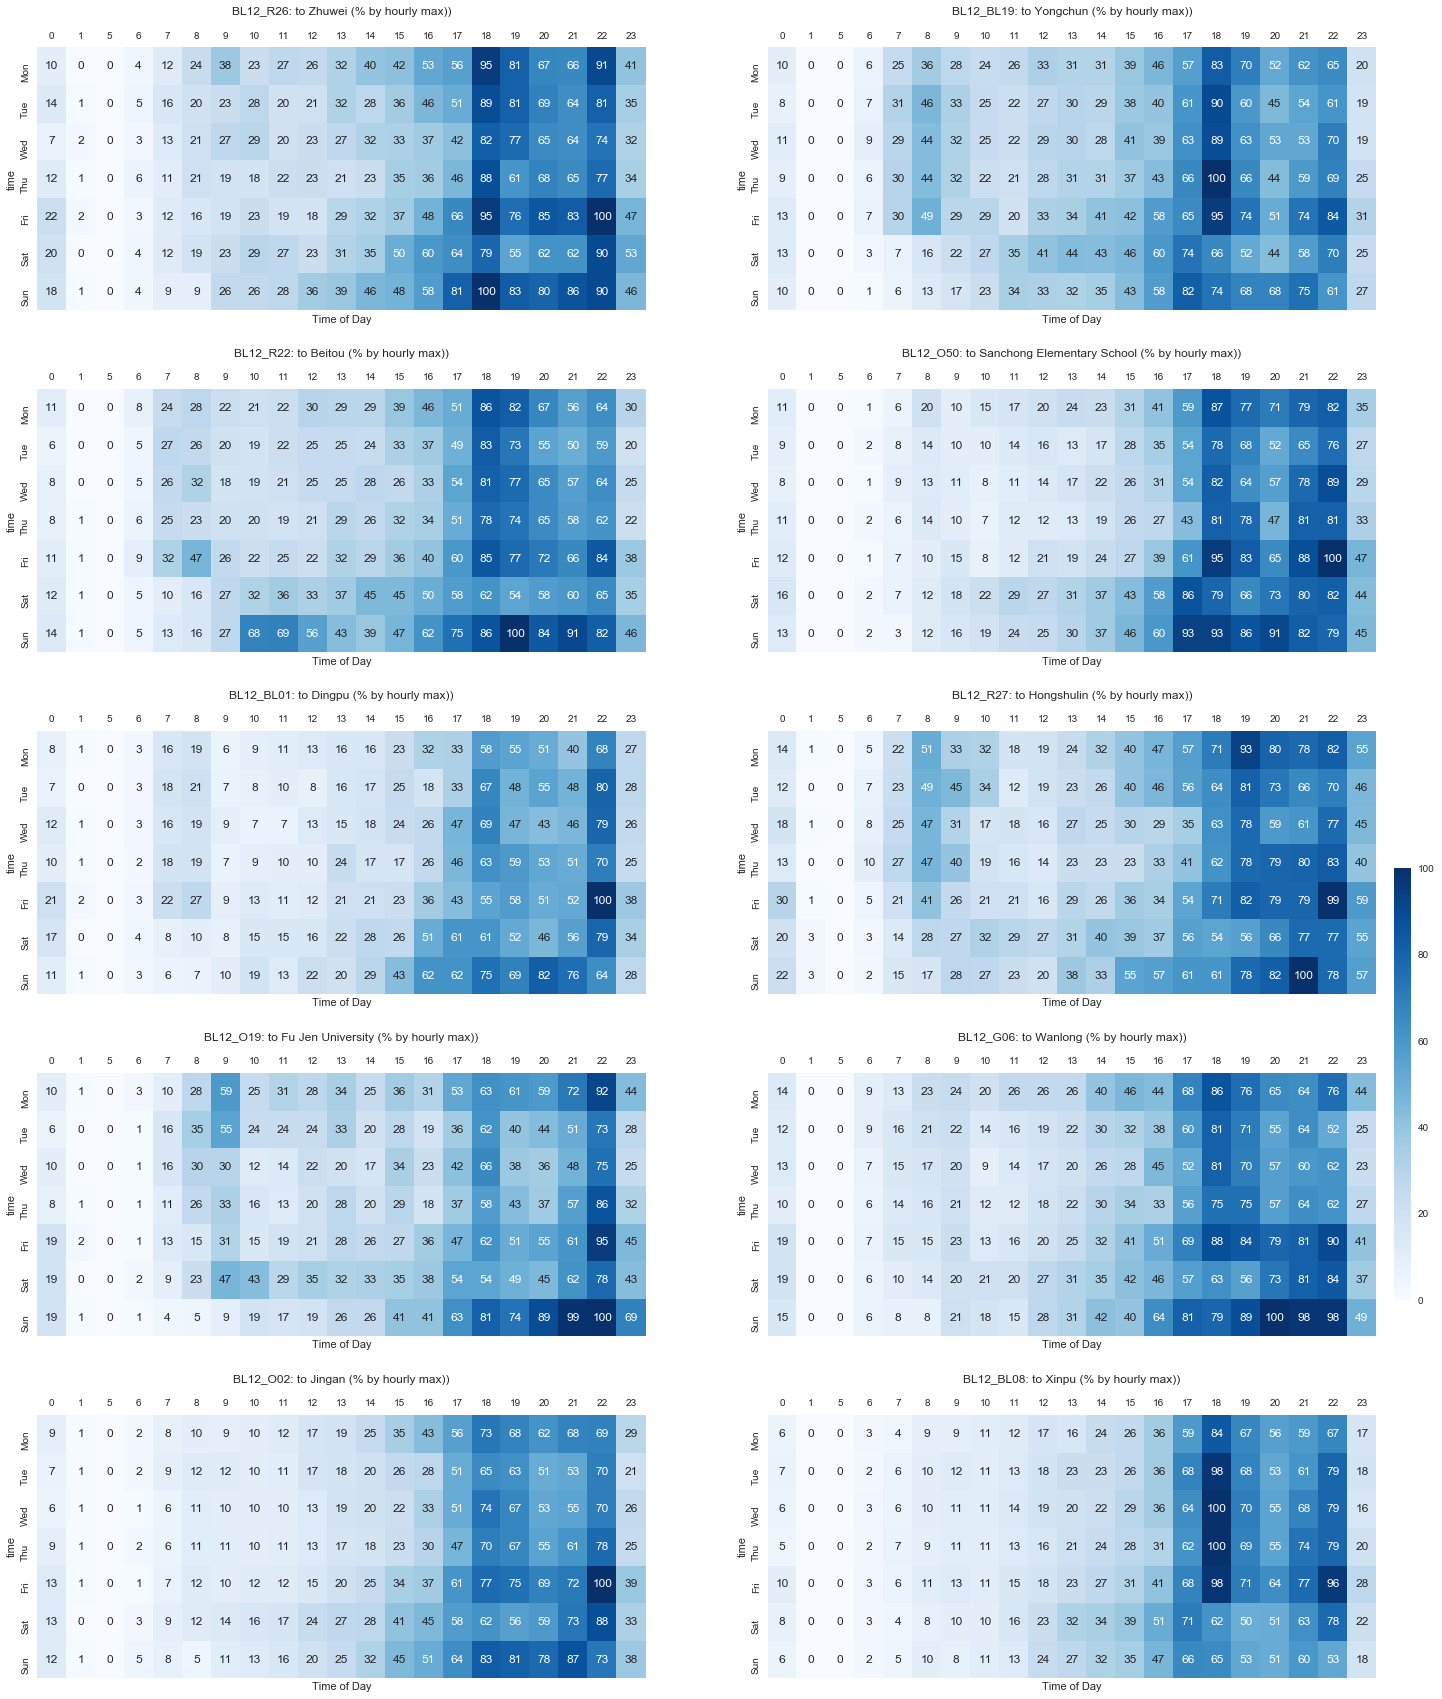

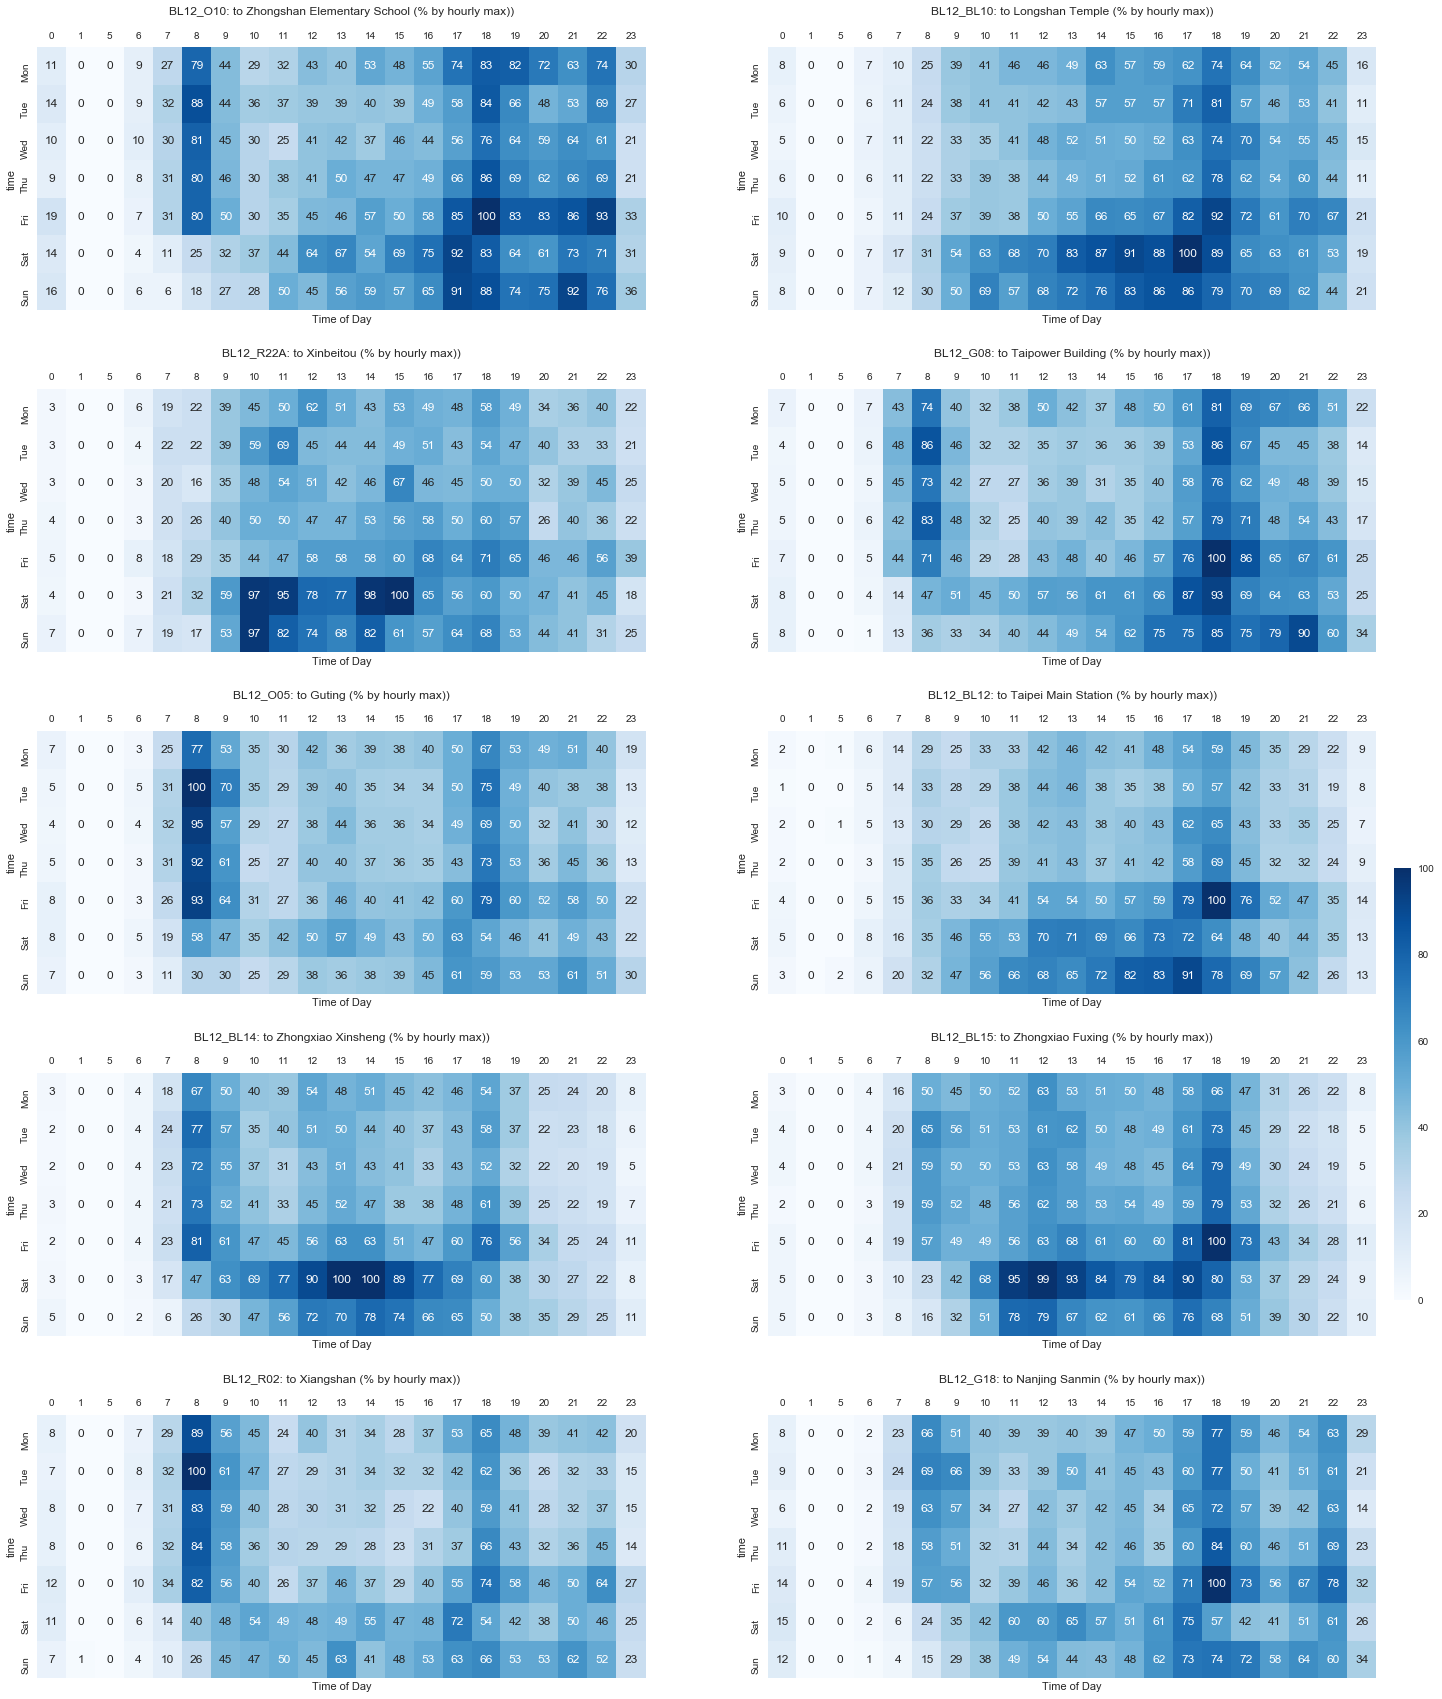

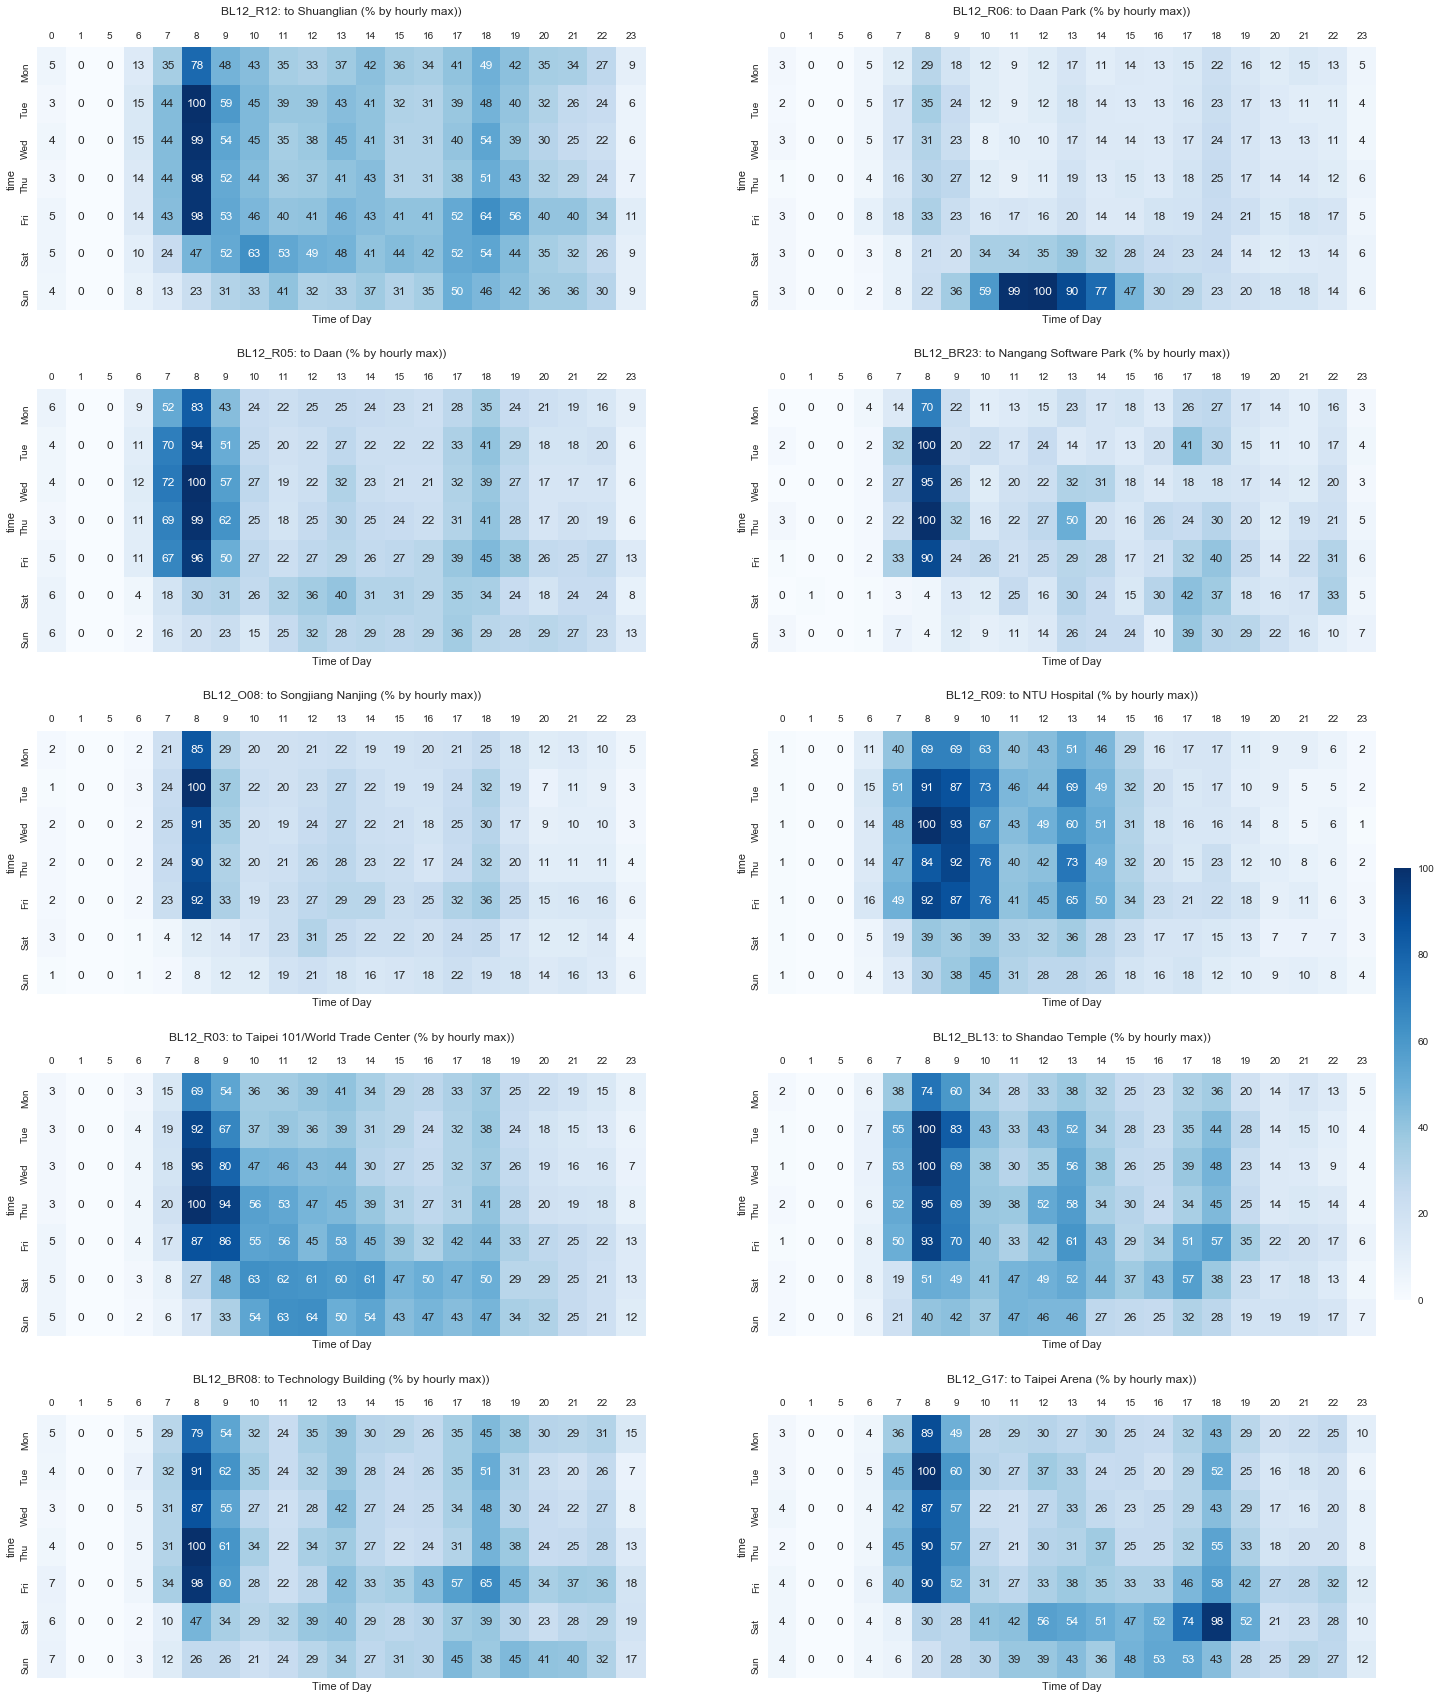

In [14]:
#2.1 Create heatmap
viz.heat_map(col_num=2, example=True)

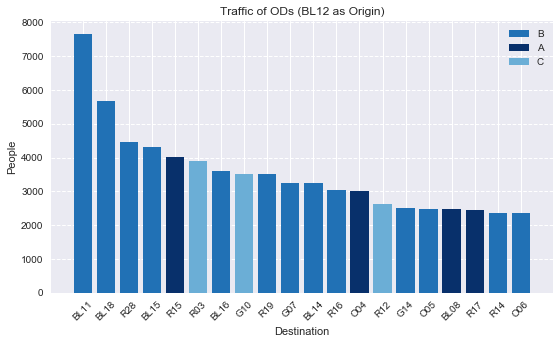

In [15]:
#2.2 Create bar graph
viz.bar_ranking(topN=20)

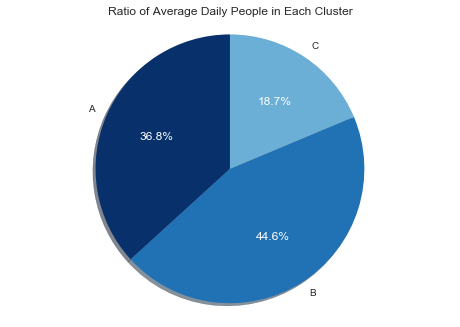

In [16]:
#2.3 Create pie chart
viz.pie_chart()